In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict
import numpy as np

In [4]:
def count_gates(qc: QuantumCircuit):
    gate_count = { qubit: 0 for qubit in qc.qubits }
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count

def remove_idle_wires(qc: QuantumCircuit):
    qc_out = qc.copy()
    gate_count = count_gates(qc_out)
    for qubit, count in gate_count.items():
        if count == 0:
            qc_out.qubits.remove(qubit)
    return qc_out

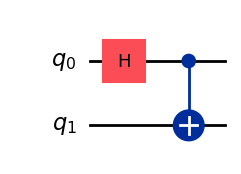

In [5]:

# Example circuits
qc_ref = QuantumCircuit(2)
qc_ref.h(0)

qc_ref.cx(0, 1)


sv_ref = Statevector.from_instruction(qc_ref)
qc_ref.draw('mpl', idle_wires=True, fold=60)



In [6]:
backend = FakeTorino()

In [7]:
from qiskit import QuantumCircuit

def copy_circuit_no_empty_lines(qc: QuantumCircuit):
    # Step 1: Store instructions and track used wires
    instructions = []
    used_qubits = set()
    used_clbits = set()

    for instr, qargs, cargs in qc.data:
        instructions.append((instr.copy(), qargs, cargs))
        used_qubits.update(qargs)
        used_clbits.update(cargs)

    # Step 2: Sort wires by their index in the original circuit
    used_qubits = sorted(used_qubits, key=lambda q: qc.qubits.index(q))
    used_clbits = sorted(used_clbits, key=lambda c: qc.clbits.index(c))

    # Step 3: Create new circuit with only used wires
    qc_copy = QuantumCircuit(len(used_qubits), len(used_clbits))

    # Create mapping from old wires to new wires
    qubit_map = {old_q: qc_copy.qubits[i] for i, old_q in enumerate(used_qubits)}
    clbit_map = {old_c: qc_copy.clbits[i] for i, old_c in enumerate(used_clbits)}

    # Step 4: Append instructions to new circuit
    for instr, qargs, cargs in instructions:
        mapped_qargs = [qubit_map[q] for q in qargs]
        mapped_cargs = [clbit_map[c] for c in cargs]
        qc_copy.append(instr, mapped_qargs, mapped_cargs)

    return qc_copy


/var/folders/_k/qjlhflx94s97dht_ggl_nt080000gn/T/ipykernel_77625/3336136814.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


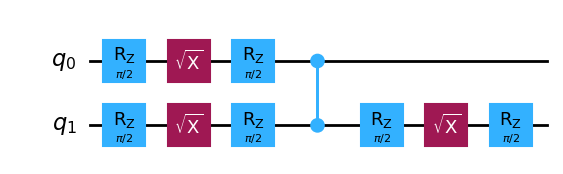

In [8]:
seed = 42

# Make a pass manager with our desired optimization level and backend
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)

# Run for our random circuit
tr_lv0 = pm_lv0.run(qc_ref)
phase = tr_lv0.global_phase
tr_lv0 = copy_circuit_no_empty_lines(tr_lv0)

# uncomment the next line to draw circuit
tr_lv0.draw('mpl', idle_wires=True, fold=60)

In [9]:
sv_transpiled = Statevector.from_instruction(tr_lv0)
# Check if the transpiled circuit matches the reference statevector
print("Transpiled circuit matches reference statevector:", sv_transpiled.equiv(sv_ref))

Transpiled circuit matches reference statevector: True


In [10]:
sv_ref

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


In [11]:

def parallel_constant(v1, v2, tol=1e-9):
    v1 = np.asarray(v1, dtype=float)
    v2 = np.asarray(v2, dtype=float)
    
    # Both zero vector case
    if np.allclose(v1, 0, atol=tol) and np.allclose(v2, 0, atol=tol):
        return None  # undefined constant for zero-zero
    
    # If one is zero vector, cannot define a constant
    if np.allclose(v1, 0, atol=tol) or np.allclose(v2, 0, atol=tol):
        return None
    
    # Avoid division by zero: compute ratio where v2 is nonzero
    nonzero_mask = np.abs(v2) > tol
    if not np.any(nonzero_mask):
        return None
    
    ratios = v1[nonzero_mask] / v2[nonzero_mask]
    
    # Check if all ratios are (almost) equal
    if np.allclose(ratios, ratios[0], atol=tol):
        return ratios[0]  # the parallel constant
    else:
        return None  # not parallel

In [12]:
from math import exp, sin, cos
import numpy as np
# convert sv_transpiled to a numpy vector
sv_transpiled = np.array(sv_transpiled)
# Rotate by phase 
rotation = cos(phase) + 1j * sin(phase)
rotated = sv_transpiled * rotation

# check if vectors are parallel
c = parallel_constant(sv_ref, rotated)

print(rotated)
print(np.array(sv_ref))

# These two are equal! We did it!


[ 7.07106781e-01+2.00513608e-15j -1.47476458e-31+5.55111512e-17j
 -1.40037088e-31+5.55111512e-17j  7.07106781e-01+1.91037261e-15j]
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


/Users/bigman/Documents/Programming/qiskit_hackathon/.venv/lib/python3.12/site-packages/qiskit/quantum_info/states/statevector.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.data, dtype=dtype, copy=copy)
/var/folders/_k/qjlhflx94s97dht_ggl_nt080000gn/T/ipykernel_77625/1916958806.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  v2 = np.asarray(v2, dtype=float)


In [14]:
from erft_quantum import erft

EPSILON = 0.10  # 10% error tolerance
DELTA = 0.05   # 5% chance of failure (95% confidence)
seed = 0


# Test ertf on the two circuits
erft_result = erft(tr_lv0, qc_ref, epsilon=EPSILON, delta=DELTA, seed=seed)
print("ERTF result:", erft_result)




🔬 Starting ERFT for 2-qubit circuits...
   - ε (error tolerance): 0.1
   - δ (failure probability): 0.05
   - m (required samples): 185

🚀 Running 185 randomized trials...

📊 Results:
   - Total 'survival' counts: 185 / 185
   - Estimated Fidelity (F_hat): 1.0000
   - Decision Threshold (1 - ε): 0.9000
   - Outcome: F_hat ≥ 1 - ε
ERTF result: ✅ Equivalent (within ε)
